In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from tensorflow.math import confusion_matrix

import pickle



In [2]:
# load npy file

X_train = np.load('x_train_pca.npy')
y_train = np.load('y_train.npy')

X_test = np.load('x_test_pca.npy')
y_test = np.load('y_test.npy')

# load PCA models

pca_b = pickle.load(open('pca_b.pkl', 'rb')) # blue channel
pca_g = pickle.load(open('pca_g.pkl', 'rb')) # green channel
pca_r = pickle.load(open('pca_r.pkl', 'rb')) # red channel

In [3]:
# print shape

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1280, 224, 150, 3)
(1280,)
(320, 224, 150, 3)
(320,)


In [4]:
# print type

print(type(X_train))
print(type(y_train))

print(type(X_test))
print(type(y_test))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# PCA helper functions


In [5]:
def split_rgb(img):
    blue,green,red = cv2.split(img)
    return blue,green,red

def apply_pca(blue,green,red):
    # Apply PCA to the image channels (RGB). This will allow us to reduce the dimensionality of our data from 3D -> 1
    blue = pca_b.transform(blue)
    green = pca_g.transform(green)
    red = pca_r.transform(red)
    return blue, green, red

def inverse_pca(blue,green,red):
    # Apply PCA to the image channels (RGB). This will allow us to reduce the dimensionality of our data from 3D -> 1
    blue = pca_b.inverse_transform(blue)
    green = pca_g.inverse_transform(green)
    red = pca_r.inverse_transform(red)
    return blue, green, red

def merge_channels(blue,green,red):
    img_reduced= (cv2.merge((blue, green, red)))
    return img_reduced

def apply_pca_to_all_images(X):
    X_pca = []
    for i in range(len(X)):
        img = X[i]
        blue,green,red = split_rgb(img)
        blue,green,red = apply_pca(blue,green,red)
        img_reduced = merge_channels(blue,green,red)
        X_pca.append(img_reduced)
    return X_pca

def inverse_pca_to_all_images(X):
    X_pca = []
    for i in range(len(X)):
        img = X[i]
        blue,green,red = split_rgb(img)
        blue,green,red = inverse_pca(blue,green,red)
        img_reduced = merge_channels(blue,green,red)
        X_pca.append(img_reduced)
    return X_pca


In [6]:
output_map={
    7:"NV",
    6:"MEL",
    5:"BCC",
    4:"BKL",
    3:"AK",
    2:"SCC",
    1:"VASC",
    0:"DF"
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


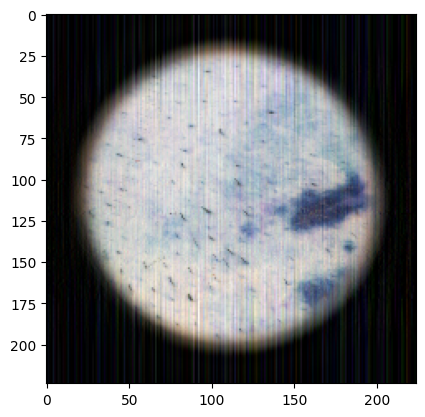

In [7]:
# show img
img=X_train[10]
blue,green,red=split_rgb(img)
blue,green,red=inverse_pca(blue,green,red)
img_reduced=merge_channels(blue,green,red)
plt.imshow(img_reduced)

plt.show()

# Designing Neural Network

In [8]:

# create model

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(224, 150,3)),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(8, activation='sigmoid')
])


In [9]:

# compile model
model.compile(
    optimizer='adam', 
    loss="sparse_categorical_crossentropy", 
    metrics=['accuracy']
)

In [10]:
# train model
model.fit(X_train,y_train, epochs=30)


Epoch 1/30
40/40 [==============================] - 31s 374ms/step - loss: 5.7514 - accuracy: 0.1883
Epoch 2/30
40/40 [==============================] - 14s 360ms/step - loss: 3.2490 - accuracy: 0.3078
Epoch 3/30
40/40 [==============================] - 15s 388ms/step - loss: 2.1928 - accuracy: 0.4523
Epoch 4/30
40/40 [==============================] - 15s 378ms/step - loss: 1.6500 - accuracy: 0.5461
Epoch 5/30
40/40 [==============================] - 15s 375ms/step - loss: 1.3592 - accuracy: 0.6055
Epoch 6/30
40/40 [==============================] - 17s 421ms/step - loss: 1.1278 - accuracy: 0.6805
Epoch 7/30
40/40 [==============================] - 16s 398ms/step - loss: 1.1052 - accuracy: 0.6820
Epoch 8/30
40/40 [==============================] - 16s 390ms/step - loss: 0.9585 - accuracy: 0.7359
Epoch 9/30
40/40 [==============================] - 14s 360ms/step - loss: 0.6940 - accuracy: 0.8023
Epoch 10/30
40/40 [==============================] - 14s 354ms/step - loss: 0.6284 - accura

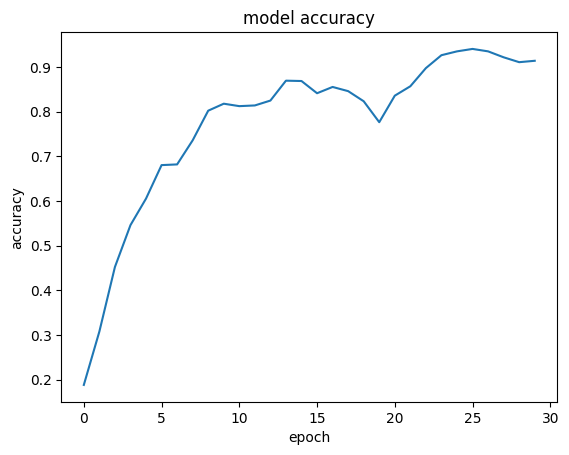

In [11]:
# plot epochs graphs

plt.plot(model.history.history['accuracy'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

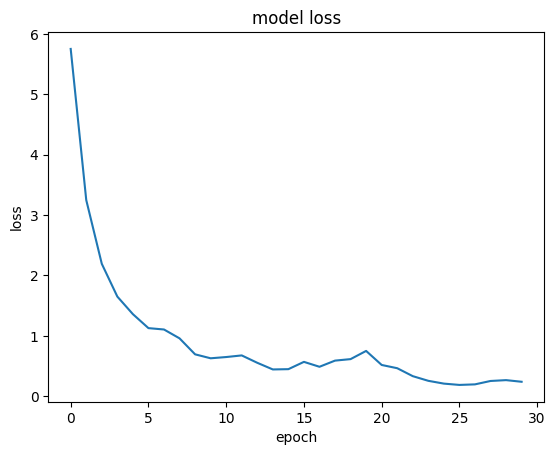

In [12]:
# plot epochs graphs

plt.plot(model.history.history['loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [13]:
# evaluate model

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

10/10 - 1s - loss: 3.7253 - accuracy: 0.3375 - 1s/epoch - 134ms/step

Test accuracy: 0.3375000059604645


Too less - Model overfitted

In [14]:
y= model.predict(X_test)
y.shape

10/10 [==============================] - 1s 43ms/step


(320, 8)

In [15]:
y_lab= [np.argmax(i) for i in y]

In [17]:
print(y_lab)

[0, 1, 1, 0, 7, 6, 6, 1, 3, 2, 2, 5, 7, 6, 2, 0, 0, 6, 1, 5, 1, 3, 6, 1, 0, 3, 3, 7, 5, 2, 4, 5, 4, 3, 3, 7, 7, 2, 7, 6, 3, 0, 4, 2, 0, 0, 2, 0, 0, 6, 0, 5, 0, 1, 1, 7, 1, 6, 0, 3, 1, 6, 1, 0, 1, 0, 0, 6, 3, 3, 6, 2, 3, 6, 0, 7, 7, 2, 4, 1, 6, 7, 3, 3, 6, 4, 7, 6, 1, 5, 7, 2, 6, 2, 1, 0, 3, 3, 5, 6, 0, 5, 1, 2, 2, 1, 1, 1, 0, 1, 7, 2, 1, 1, 2, 1, 1, 6, 2, 6, 6, 4, 1, 3, 1, 1, 1, 5, 3, 3, 3, 1, 7, 0, 3, 5, 7, 6, 4, 7, 4, 1, 7, 0, 2, 1, 0, 0, 6, 5, 3, 4, 1, 0, 4, 1, 6, 2, 1, 6, 0, 3, 3, 1, 5, 4, 4, 6, 0, 3, 1, 4, 1, 3, 1, 1, 4, 5, 4, 2, 3, 6, 0, 0, 7, 1, 0, 0, 3, 1, 7, 7, 7, 1, 6, 6, 3, 0, 2, 4, 7, 1, 0, 1, 1, 1, 3, 1, 3, 7, 2, 3, 3, 6, 0, 0, 2, 3, 4, 3, 7, 3, 6, 6, 0, 1, 2, 5, 0, 6, 6, 7, 7, 1, 2, 5, 4, 3, 2, 3, 7, 4, 4, 0, 1, 3, 1, 0, 3, 7, 2, 7, 6, 7, 0, 6, 0, 3, 3, 4, 5, 3, 7, 6, 2, 3, 0, 0, 6, 3, 4, 0, 7, 7, 2, 7, 6, 1, 1, 7, 0, 4, 7, 1, 4, 6, 6, 1, 3, 2, 2, 2, 1, 2, 0, 0, 7, 3, 3, 3, 3, 6, 6, 1, 1, 6, 2, 1, 5, 1, 4, 1, 4, 2, 2, 5, 2, 4, 7, 3]


In [18]:
confusion_matrix(y_test,y_lab)

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[19,  3,  4,  6,  2,  1,  4,  2],
       [ 2, 30,  2,  0,  3,  3,  3,  5],
       [ 6,  3, 14, 14,  2,  3,  3,  2],
       [ 6,  4,  4, 10,  3,  2,  4,  2],
       [ 2,  2,  4,  4,  5,  1,  9,  8],
       [ 6,  5,  6,  6,  3,  8,  3,  7],
       [ 5,  5,  2,  7,  5,  0, 10,  2],
       [ 1,  9,  0,  3,  4,  0,  7, 10]])>

In [19]:
accuracy_score(y_test,y_lab)

0.33125